In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

import matplotlib as mpl

from scipy import interpolate
import scipy.optimize

from copy import deepcopy
import time
from tqdm import tqdm

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *

from netgen.occ import *
from netgen.meshing import IdentificationType

# Solve the non-linear Poisson equation for a graphene nano ribbon

Siyar Duman, TU Wien

$\epsilon\Delta\phi = \rho(\phi)$

$\epsilon$ is the permittivity

$\phi$ is the electric potential

 $\rho(\phi)$ is the charge density for a graphene nano ribbon of a given width $w$. As a model, we take equation 13 in Appl. Phys. Lett. 91, 092109 (2007)
 
 Below, the function charge_density_GNR(energy, w) is  $\rho(\phi)$. It is continuous, but not differentiable at every point and shows a large constant plateau at the center (Bandgap).

## Constants and Functions

In [2]:
### CONSTANTS. In the following we use ATOMIC UNITS.
## In atomic units, bohr_radius = 1, h_bar = 1, electron_charge = 1, electron_mass = 1

nm = 18.8972613
Angstrom = 0.1*nm
Volt = 0.036749322 
epsilon_0 = 0.07958
grapheneheight = 3.35*Angstrom


c_light = 137.037 ### speed of light in atomic units

v_F =  0.003335 * c_light
    
### epsilon, permittivity
    
inplane_hBn_bulk = 4.98 ### see https://www.nature.com/articles/s41699-018-0050-x 
outofplane_hBn_bulk = 3.03

inplane_graphene = 1.8 ### https://pubs.acs.org/doi/10.1021/nl303611v
outofplane_graphene = 3
    
    
eps_dict = {"hBn" : CoefficientFunction((inplane_hBn_bulk, 0, 0,
                             0, inplane_hBn_bulk, 0,
                             0, 0, outofplane_hBn_bulk),dims=(3,3)),
                        "GNR" : CoefficientFunction((inplane_graphene, 0, 0,
                             0, inplane_graphene, 0,
                             0, 0, outofplane_graphene),dims=(3,3))}


In [3]:
def generate_charge_density(gfu, alpha = 1):

    potential  = np.zeros((npts,npts))
    
    potential = (gfu(meshptsGNR).reshape(npts,npts))
    
    charge = np.zeros((npts,npts))
    
    for j in range(npts):
        
        for i in range(npts):
            
            charge[j,i] = evaluate_interpolated_charge_density(potential[j,i])
            
    if alpha != 1:
        
        charge = alpha * charge
            

    return charge, potential

In [4]:
def put_charge_on_grid(values, gfQ):
    
    nz = 3
    
    new_values = np.zeros(npts*npts*nz)
    
    new_values = new_values.reshape(npts,npts,nz)
    
    new_values = new_values.reshape(nz,npts,npts)
    
    for nn in range(nz):
        
        for ny in range(npts):
            
            for nx in range(npts):
                
                new_values[nn][ny][nx] = values[nx][ny]
    
    
    func = VoxelCoefficient((0, 0, height), 
            (box_width, box_width, height + grapheneheight), new_values)
    
    gfQ.Set(func)

In [5]:
def E_n(n, w): # E_n defined below eq. 8
    
    return (n*np.pi*v_F)/w

def get_number_of_states(energy, w):
    
    energy = np.abs(energy)
    
    n_energy = energy * (w / (np.pi*v_F))
    
    n_energy = int(np.floor(n_energy))
    
    if n_energy == 0:
        
        inside_bandgap = True
    
    else:
    
        inside_bandgap = False
    
    return n_energy, inside_bandgap

def carrier_concentration(energy, w):
    
    
    n_energy, inside_bandgap = get_number_of_states(energy, w)
    
    if inside_bandgap == True:
        
        return 0
    
    sum_carrier = 0
    
    for j in range(1, n_energy + 1):
        
        dummy_E_n = E_n(j, w)
        
        sum_carrier += np.sqrt(energy*energy - dummy_E_n * dummy_E_n)
        
    sum_carrier = sum_carrier * 4.0 / (np.pi*v_F)
    
    return sum_carrier


def charge_density_GNR(energy, w):
    
    if energy == 0:
        
        return 0
    
    if energy > 0: # electrons
        
        density =  - carrier_concentration(energy, w) / (grapheneheight * w) ## this is in units of 1/Bohr radius^3
        
        return density
        
    if energy < 0: # holes
        
        density = carrier_concentration(energy, w) / (grapheneheight * w) ## this is in units of 1/Bohr radius^3
        
        return density

In [6]:
chosen_width = 5

en_steps = 20000

pot_max = 30

pot_min = -30

en_intervall = np.linspace(pot_min, pot_max, en_steps)

values_charge_density_GNR = np.zeros(en_steps)

for i, en in enumerate(en_intervall):
    
    values_charge_density_GNR[i] = charge_density_GNR(en*Volt, chosen_width * nm)
    

interpolated_charge_density_GNR = scipy.interpolate.interp1d(en_intervall*Volt, values_charge_density_GNR)



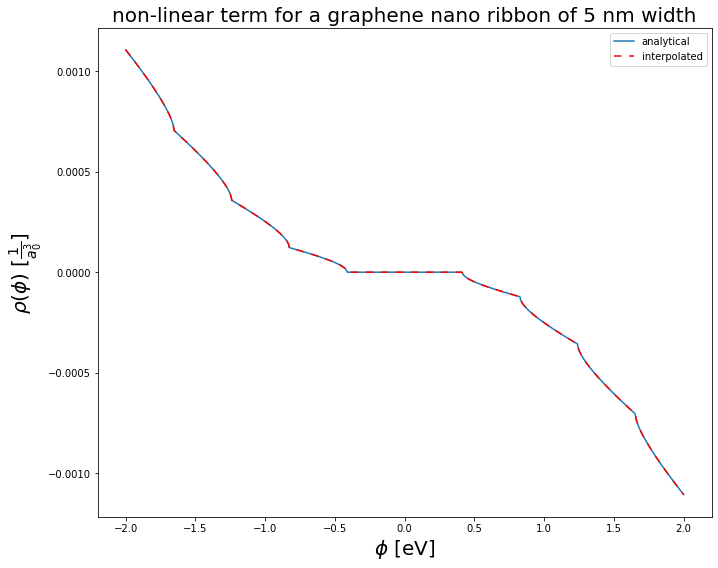

In [7]:
plot_en_steps = 1000

plot_pot_max = 2

plot_pot_min = -2


plot_en_intervall = np.linspace(plot_pot_min, plot_pot_max, plot_en_steps)

plot_charge_density_GNR = np.zeros(plot_en_steps)

for i, en in enumerate(plot_en_intervall):

    plot_charge_density_GNR[i] = charge_density_GNR(en*Volt, chosen_width * nm)



values_interpolated_charge_density_GNR = np.zeros(plot_en_steps)

for i, en in enumerate(plot_en_intervall*Volt):
    
    values_interpolated_charge_density_GNR[i] = interpolated_charge_density_GNR(en)
    

plt.figure(figsize=(11,9))
plt.plot(plot_en_intervall, plot_charge_density_GNR, label="analytical")
plt.plot(plot_en_intervall, values_interpolated_charge_density_GNR, linestyle=(0, (5, 5)), label="interpolated", c="red")
plt.xlabel(r"$\phi$ [eV]", fontsize=20)
plt.ylabel(r"$\rho(\phi)$ [$\frac{1}{a_0^3}$]", fontsize=20)
plt.title("non-linear term for a graphene nano ribbon of "+str(chosen_width) + " nm width", fontsize=20)
plt.legend()
plt.show()

In [8]:
small_delta = pow(10,-5)

pot_min_in_Volt = pot_min*Volt

pot_max_in_Volt = pot_max*Volt


### we use the interpolated function since it is much cheaper to evaluate

def evaluate_interpolated_charge_density(pot):
    
    # if potential is beyond intervall, map it to the boundary
    
    # avoid boundary evaluation; shift by small_delta
    

    if pot <= pot_min_in_Volt: 
        
        pot = pot_min_in_Volt + small_delta
        
    if pot >= pot_max_in_Volt:
        
        pot = pot_max_in_Volt - small_delta
        
    return interpolated_charge_density_GNR(pot)

## Geometry consists of a Bottom Gate, Insulating Material (hBn), GNR, and top cylinder gate 

In [9]:
box_width = chosen_width * nm

height = grapheneheight*4

cylinder_radius = chosen_width * nm * 0.07


maxh = 5 * Angstrom

hBn_bottom = Box(Pnt(0 ,0 ,0 ), Pnt(box_width, box_width, height))

GNR = Box(Pnt(0 ,0 , height), Pnt(box_width, box_width, height + grapheneheight))

hBn_top = Box(Pnt(0 ,0 , height + grapheneheight), Pnt(box_width, box_width, 2*height + grapheneheight))

cylinder_gate = Cylinder(Pnt(box_width/2, box_width/2, 2*height + grapheneheight), Z, r=cylinder_radius, h=height/2)


hBn_bottom.mat("hBn");

GNR.mat("GNR");

hBn_top.mat("hBn");


cylinder_gate.bc("top");

hBn_bottom.faces.Min(Z).name = "bottom"



geo = OCCGeometry([hBn_bottom, GNR, hBn_top, cylinder_gate])


mesh = Mesh(geo.GenerateMesh(maxh=maxh)).Curve(3)


npts = 200

xs   = np.linspace(0, box_width, npts)
ys   = np.linspace(0, box_width, npts)

ptsGNR = np.zeros( (len(xs)*len(ys),3))  

for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        nr = j+i*len(ys)
        ptsGNR[nr,0] = x
        ptsGNR[nr,1] = y
        ptsGNR[nr,2] = height + grapheneheight/2

            
meshptsGNR = mesh(ptsGNR[:,0], ptsGNR[:,1], ptsGNR[:,2])

In [10]:
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## solve once for right-hand side = 0

In [11]:
bottom = 2  # chosing bottom = 1 leaves the potential inside the bandgap, 
            # no charge and iteration stops immediately. try it out!

top = -7

bound_dict = {'bottom' : bottom*Volt, 'top' :top*Volt}


start = time.time()

##### solve once

fes = H1(mesh, order=2, dirichlet="bottom|top")   


print ("ndof=", fes.ndof)
epsr = mesh.MaterialCF( eps_dict )
u, v = fes.TnT()
a = BilinearForm(epsilon_0 * epsr * grad(u) * grad(v) * dx)

a.Assemble()


gfu  = GridFunction(fes)
gfud = mesh.BoundaryCF( bound_dict, default=0)
gfu.Set(gfud, BND)

inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")


res = (a.mat * gfu.vec).Evaluate()

gfu.vec.data -= inv * res


Draw(gfu);

end = time.time()

print(end-start)

ndof= 6469


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

0.162400484085083


## Solve non-linear Poisson's equation iteratively

In [12]:
def residual_of_charge(charge):
    
    charge = charge.reshape((npts,npts))
    
    u, v = fes.TnT()

    put_charge_on_grid( charge, gfQ)
    
    #update right side of poisson equation
    with TaskManager():
        
        f   = LinearForm( gfQ * v * dx("GNR")).Assemble()
        
        gfu.Set(gfud, BND)

        res = (a.mat * gfu.vec - f.vec).Evaluate()
    
        gfu.vec.data -= inv * res
        

    new_charge, new_potential = generate_charge_density(gfu)
        
    ### plot charges, their differences and the new potential
    
    box_extent = [0, chosen_width, 0, chosen_width]
    
    plt.figure(figsize=(11,8))
    
    gs=gridspec.GridSpec(1,4, wspace = 0.6)
    
    ax = plt.subplot(gs[0,0])
    
    img = ax.imshow(charge.T*pow(nm,3), extent = box_extent)
    
    plt.xlabel("x [nm]")
    plt.ylabel("y [nm]")
    plt.title(r"$\rho_{s}$ in $[\frac{1}{nm^3}]$")
    
    plt.colorbar(img, ax=ax,fraction=0.046, pad=0.04)
    
    ax2 = plt.subplot(gs[0,1])
    
    img2 = ax2.imshow(new_charge.T*pow(nm,3), extent = box_extent)
    
    plt.xlabel("x [nm]")
    plt.ylabel("y [nm]")
    plt.title(r"$\rho[\phi_s,\vec\nabla\phi_s]$ in $[\frac{1}{nm^3}]$")
    
    plt.colorbar(img2, ax=ax2,fraction=0.046, pad=0.04)
    
    ax3 = plt.subplot(gs[0,2])
    
    img3 = ax3.imshow((new_charge.T - charge.T), extent = box_extent)
    
    plt.xlabel("x [nm]")
    plt.ylabel("y [nm]")
    plt.title(r"$\delta[\rho_s]$")
    
    plt.colorbar(img3, ax=ax3,fraction=0.046, pad=0.04)
    
    ax4 = plt.subplot(gs[0,3])
    
    img4 = ax4.imshow(new_potential.T/Volt*pow(10,3), extent = box_extent)
    
    plt.xlabel("x [nm]")
    plt.ylabel("y [nm]")
    plt.title(r"$\phi_{s}$ in $[meV]$")
    
    plt.colorbar(img4, ax=ax4,fraction=0.046, pad=0.04)
    
    plt.suptitle("iteration " + str(n_it[0]), y=0.7)
    
    plt.show()
    
    n_it[0] += 1
    
    saved_charges.append(new_charge)
    
    saved_potentials.append(new_potential)
    
    charge = charge.reshape(npts*npts)

    new_charge = new_charge.reshape(npts*npts)

    return  (charge - new_charge)

ndof= 6469


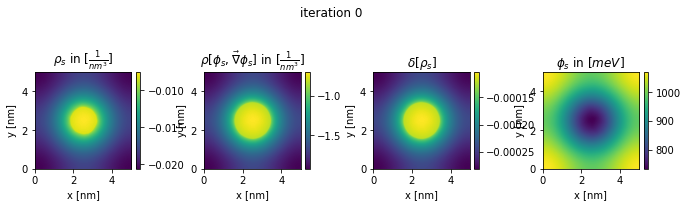

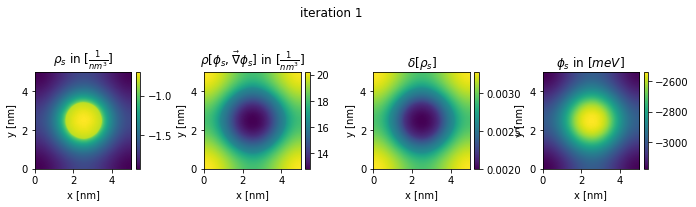

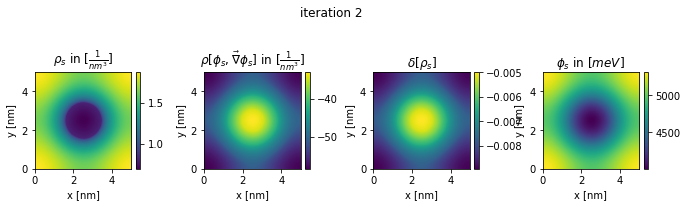

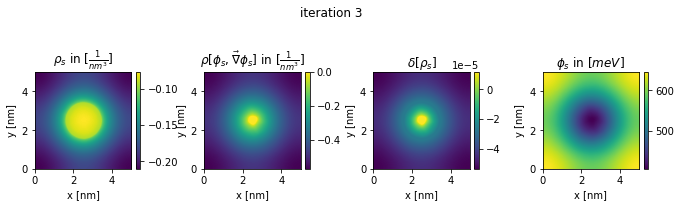

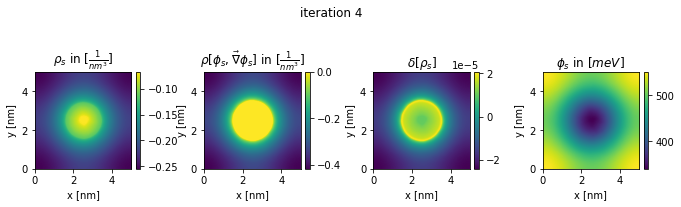

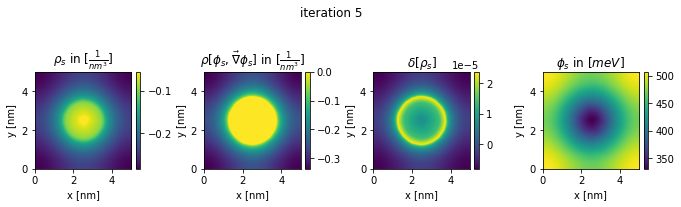

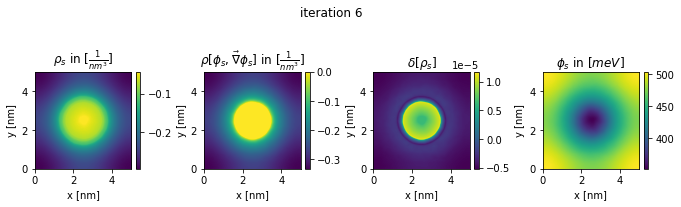

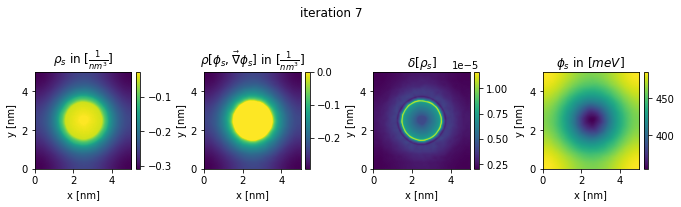

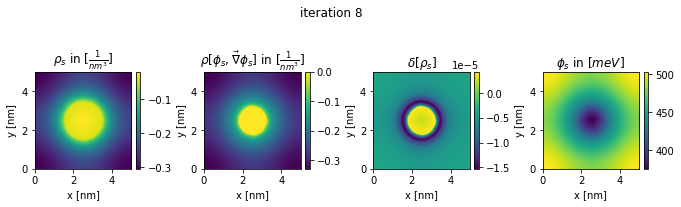

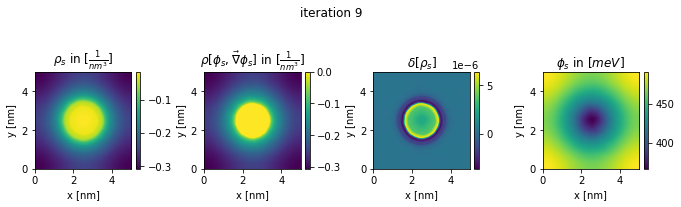

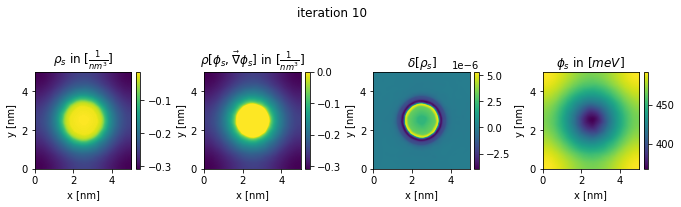

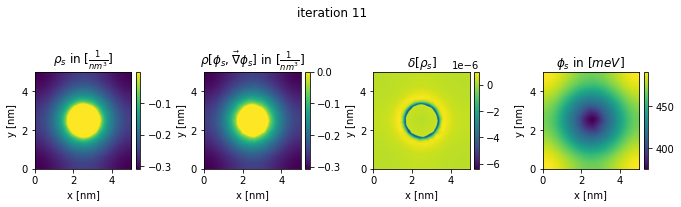

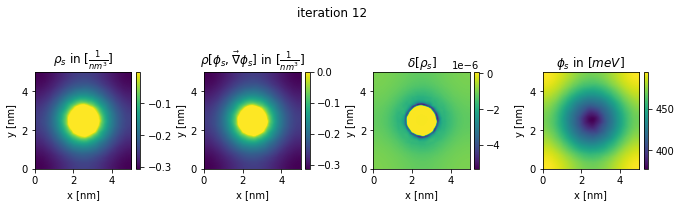

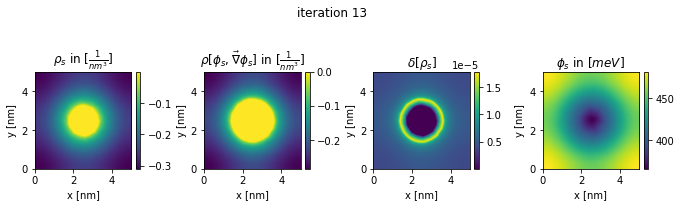

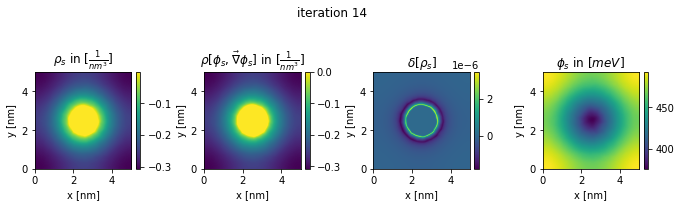

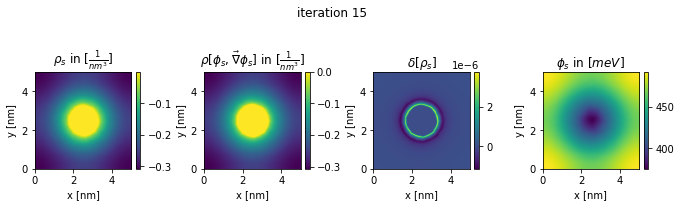

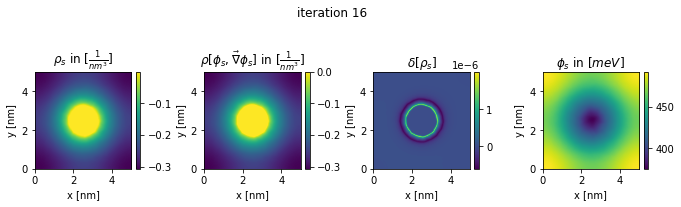

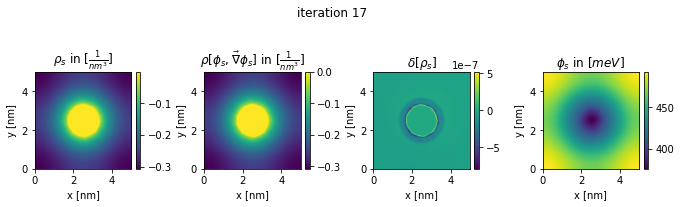

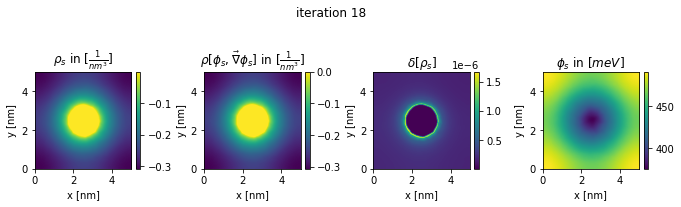

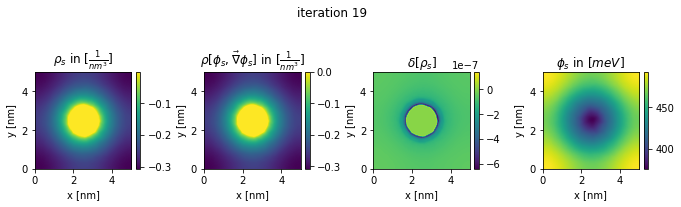

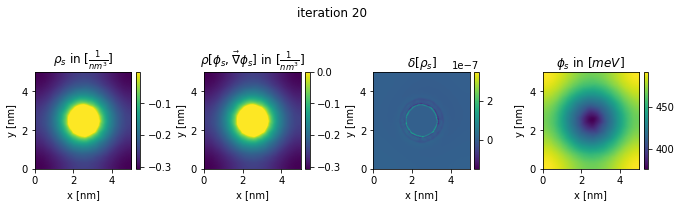

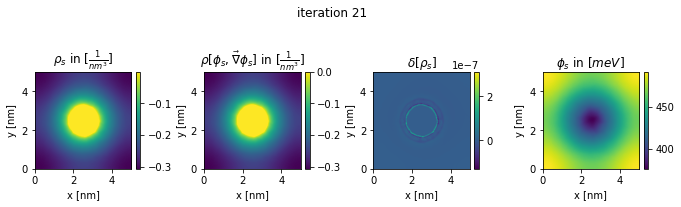

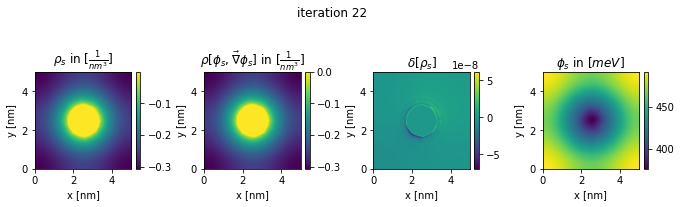

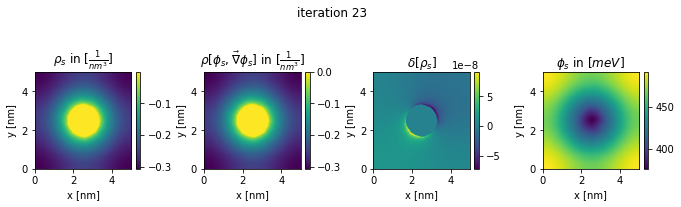

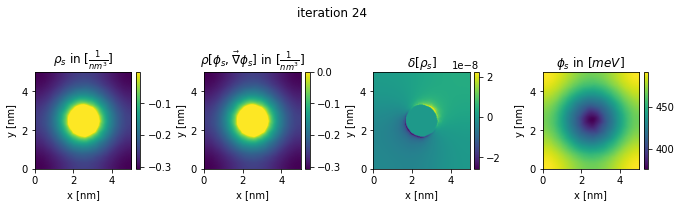

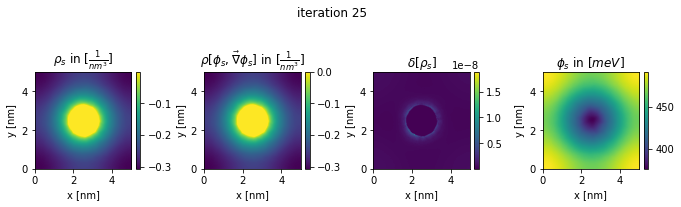

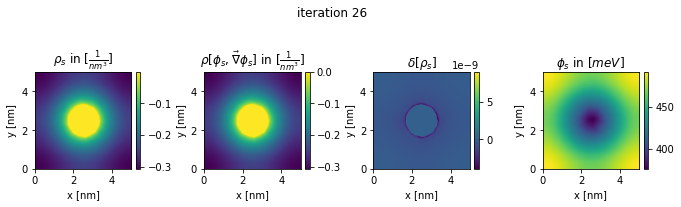

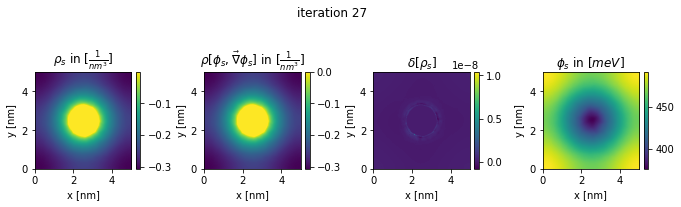

In [13]:
fes = H1(mesh, order=2, dirichlet="bottom|top")   

gfu  = GridFunction(fes)
gfud = mesh.BoundaryCF( bound_dict, default=0)

fesQ   = L2(mesh, order=2, definedon=mesh.Materials("GNR"))
gfQ    = GridFunction(fesQ)
gfQ.Set(0)


print ("ndof=", fes.ndof)
epsr = mesh.MaterialCF( eps_dict )



#### solve once, generate initial guess



u, v = fes.TnT()
a = BilinearForm(epsilon_0 * epsr * grad(u) * grad(v) * dx).Assemble() 

gfu  = GridFunction(fes)
gfud = mesh.BoundaryCF( bound_dict, default=0)
gfu.Set(gfud, BND)

inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")


res = (a.mat * gfu.vec).Evaluate()

gfu.vec.data -= inv * res


charge, potential = generate_charge_density(gfu, alpha = 0.01) # alpha = 1

saved_charges = [charge]

saved_potentials = [potential]

n_it = [0]


#### cycle

    
sol = scipy.optimize.root(residual_of_charge, 
                charge,
                method='df-sane', options = {"fatol": pow(10,-7)}) #method='krylov'


In [14]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

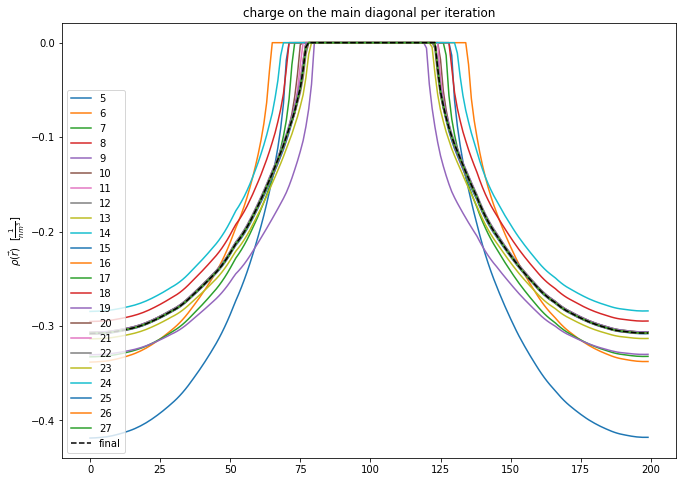

In [15]:
n_it = len(saved_charges)

plt.figure(figsize=(11,8))


for i in range(n_it):
    
    if i < 5:
        
        continue
        
    if i != n_it - 1:
    
        plt.plot(np.diag(saved_charges[i])*pow(nm,3), label = str(i))
        
    else:
        
        plt.plot(np.diag(saved_charges[i])*pow(nm,3), label = "final", color="black", linestyle="dashed")
    
plt.title("charge on the main diagonal per iteration")

plt.ylabel(r"$\rho(\vec r)$  $[\frac{1}{nm^3}]$")
    
plt.legend(loc="lower left")

plt.show()

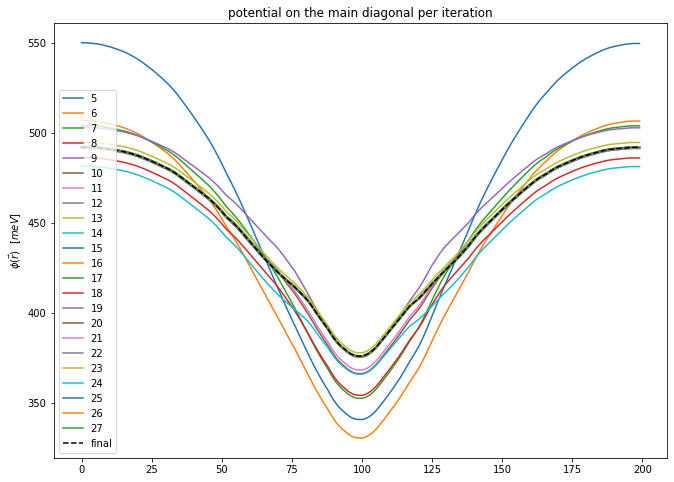

In [16]:
n_it = len(saved_charges)

plt.figure(figsize=(11,8))


for i in range(n_it):
    
    if i < 5:
        
        continue
        
    if i != n_it - 1:
    
        plt.plot(np.diag(saved_potentials[i])*pow(10,3)/Volt, label = str(i))
        
    else:
        
        plt.plot(np.diag(saved_potentials[i])*pow(10,3)/Volt, label = "final", color="black", linestyle="dashed")
    
plt.title("potential on the main diagonal per iteration")

plt.ylabel(r"$\phi(\vec r)$  $[meV]$")
    
plt.legend(loc = "lower left")

plt.show()

In [20]:
charge_in_GNR = Integrate(gfQ, mesh, definedon=mesh.Materials("GNR"))

print("Charge in the graphene nano ribbon is", charge_in_GNR, "electrons")

Charge in the graphene nano ribbon is -1.7366957945818493 electrons


In [18]:
# find bandgap:

incr = (pot_max - pot_min) / (en_steps - 1)

found_left = False

found_right = False

threshold = pow(10,-7)

for i in range(int(en_steps/2)):
    
    if found_left == True and found_right == True:
        
        break
    
    left_val = values_charge_density_GNR[int(en_steps/2) - i]
    
    right_val = values_charge_density_GNR[int(en_steps/2) + i]
    
    if np.abs(left_val) > threshold and found_left == False:
        
        found_left = True
        
        left_index = int(en_steps/2) - i
        
    if np.abs(right_val) > threshold and found_right == False:
        
        found_right = True
        
        right_index = int(en_steps/2) + i
        

band_gap = (right_index - left_index) * incr

print("The bandgap is", band_gap*pow(10,3), "meV")

The bandgap is 831.0415520776039 meV


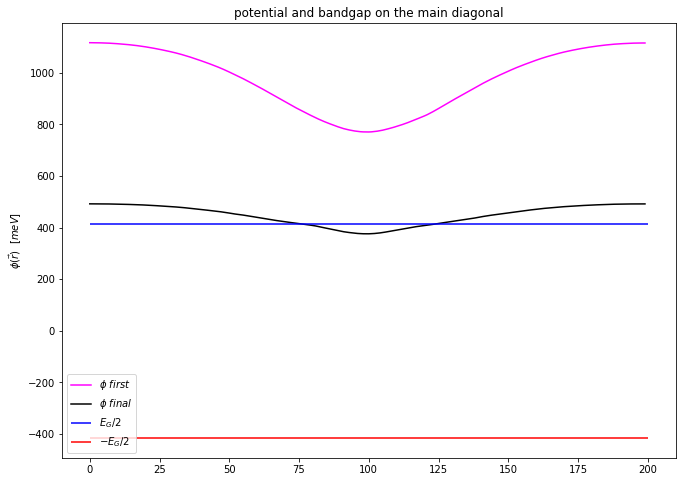

In [19]:
plt.figure(figsize=(11,8))

plt.plot(np.diag(saved_potentials[0])*pow(10,3)/Volt, label = r"$\phi$ $first$", color = "magenta")

plt.plot(np.diag(saved_potentials[-1])*pow(10,3)/Volt, label = r"$\phi$ $final$", color = "black")

plt.hlines(band_gap/2*pow(10,3), 0, npts, color = "blue", label = r"$E_{G}/2$")

plt.hlines(-band_gap/2*pow(10,3), 0, npts, color = "red", label = r"$-E_{G}/2$")
    
plt.title("potential and bandgap on the main diagonal")

plt.ylabel(r"$\phi(\vec r)$  $[meV]$")
    
plt.legend()

plt.show()